In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
mb_size = 32
X_dim = [28,28,1]
z_dim = 64
h_dim = 128
lr = 1e-3
d_steps = 3
n_class = 10

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


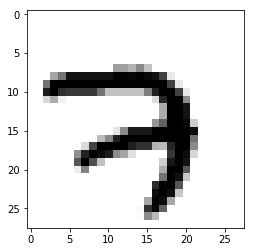

In [3]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
x_train = mnist.train.images[:50,:]
x_train = x_train.reshape([50,28,28,1])
#randomNum = random.randint(0,25)
image = x_train[0]
plt.imshow(image[:,:,0], cmap=plt.get_cmap('gray_r'))
plt.show()

In [4]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [5]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [6]:
def log(x):
    return tf.log(x + 1e-8)
    

In [7]:
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
y = tf.placeholder(tf.float32, shape=[None, n_class])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W2 = tf.Variable(xavier_init([h_dim, n_class]))
D_b2 = tf.Variable(tf.zeros(shape=[n_class]))

G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# theta_G = [G_W1, G_W2, G_b1, G_b2]
# theta_D = [D_W1, D_W2, D_b1, D_b2]

TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [ ]:
def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [ ]:
def G(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

In [ ]:
def D(X):
    D_h1 = tf.nn.relu(tf.matmul(X, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    out = tf.nn.softmax(D_h2)
    # bs x n_class
    return out, D_h2

In [ ]:
epsilon = 1.0e-6
LAMBA = 1
# y has dim batch_size x num_classes
# entropy 1
def marginal_entropy(y):
    y_1 = tf.reduce_mean(y, axis=0) #1/N sum y_i
    y_2 = -y_1 * tf.log(y_1+epsilon)
    y_3 = tf.reduce_sum(y_2)
    return y_3

def entropy(y):
    #batch_size= K.int_shape(y)[0]
    y_1 = -y * tf.log(y+epsilon)
    y_2 = tf.reduce_sum(y_1,axis=1)
    y_3 = tf.reduce_mean(y_2,axis=0)
    return y_3

In [ ]:

G_sample = G(z)

D_real, D_real_logits = D(X)
D_fake, D_fake_logits = D(G_sample)

D_target = 1./mb_size
G_target = 1./(mb_size*2)

#Z = tf.reduce_sum(tf.exp(-D_real)) + tf.reduce_sum(tf.exp(-D_fake))

#D_loss = tf.reduce_sum(D_target * D_real) + log(Z)
#G_loss = tf.reduce_sum(G_target * D_real) + tf.reduce_sum(G_target * D_fake) + log(Z)

D_loss = -marginal_entropy(D_real) + entropy(D_real) - entropy(D_fake) + tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=D_real_logits)
G_loss = -marginal_entropy(D_fake) + entropy(D_fake)

D_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(G_loss, var_list=theta_G))

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

dir_name ='out_2/'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

i = 0

In [ ]:
#100,000 is good
#print every 1000
for it in range(10000):
    X_mb, y_mb = mnist.train.next_batch(mb_size)
    X_mb = X_mb.reshape([mb_size, 28, 28 1])
    z_mb = sample_z(mb_size, z_dim)

    _, D_loss_curr = sess.run(
        [D_solver, D_loss], feed_dict={X: X_mb, z: z_mb, y: y_mb}
    )

    _, G_loss_curr = sess.run(
        [G_solver, G_loss], feed_dict={X: X_mb, z: z_mb, y: y_mb}
    )

    if it % 100 == 0:
        print('Iter: {}; D_loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))

        samples = sess.run(G_sample, feed_dict={z: sample_z(16, z_dim)})

        fig = plot(samples)
        plt.savefig(dir_name+'{}.png'
                    .format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)